In [1]:
%matplotlib widget

import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

import seaborn as sns

sns.set(context="talk", style="ticks", color_codes=True)


In [2]:
# read MaNGA examples
# extract sky spectra from blue and red channels
# plot both channel spectra
# outline sky spectra cleaning: fiber masking, pixel masking, outliers
# separate continuum from emission lines

# examples path
manga_path = os.path.abspath("./_data-manga")

filenames = sorted(os.listdir(manga_path))
filenames

['mgSFrame-b1-00198570.fits.gz', 'mgSFrame-r1-00198570.fits.gz']

In [3]:
blue_sky_path = os.path.join(manga_path, filenames[0])
blue_sky = fits.open(blue_sky_path)

blue_sky.info()

Filename: /disk-a/mejia/Research/UNAM/lvm-drp/lvmdrp/docs/nb/_data-manga/mgSFrame-b1-00198570.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     190   ()      
  1  FLUX          1 ImageHDU       194   (4112, 709)   float32   
  2  IVAR          1 ImageHDU        10   (4112, 709)   float32   
  3  MASK          1 ImageHDU        10   (4112, 709)   int32   
  4  WSET          1 BinTableHDU     30   1R x 4C   [8A, D, D, 4254D]   
  5  LSFPOST       1 ImageHDU        10   (4112, 709)   float32   
  6  LSFPRE        1 ImageHDU        10   (4112, 709)   float32   
  7  SLITMAP       1 BinTableHDU     86   1423R x 34C   [12A, J, J, 8A, J, J, 8A, J, J, J, E, J, K, J, 5A, J, 3A, J, J, J, D, D, D, D, D, D, E, E, E, J, J, J, 5E, 8A]   
  8  XPOS          1 ImageHDU        10   (4112, 709)   float32   
  9  SUPERFLAT     1 ImageHDU        10   (4112, 709)   float32   
 10  AIRSET        1 BinTableHDU     30   1R x 4C   [8A, D, D, 4254D]   
 1

In [4]:
red_sky_path = os.path.join(manga_path, filenames[1])
red_sky = fits.open(red_sky_path)

red_sky.info()

Filename: /disk-a/mejia/Research/UNAM/lvm-drp/lvmdrp/docs/nb/_data-manga/mgSFrame-r1-00198570.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     190   ()      
  1  FLUX          1 ImageHDU       194   (4128, 709)   float32   
  2  IVAR          1 ImageHDU        10   (4128, 709)   float32   
  3  MASK          1 ImageHDU        10   (4128, 709)   int32   
  4  WSET          1 BinTableHDU     36   1R x 7C   [8A, D, D, 4254D, E, E, E]   
  5  LSFPOST       1 ImageHDU        10   (4128, 709)   float32   
  6  LSFPRE        1 ImageHDU        10   (4128, 709)   float32   
  7  SLITMAP       1 BinTableHDU     86   1423R x 34C   [12A, J, J, 8A, J, J, 8A, J, J, J, E, J, K, J, 5A, J, 3A, J, J, J, D, D, D, D, D, D, E, E, E, J, J, J, 5E, 8A]   
  8  XPOS          1 ImageHDU        10   (4128, 709)   float32   
  9  SUPERFLAT     1 ImageHDU        10   (4128, 709)   float32   
 10  AIRSET        1 BinTableHDU     36   1R x 7C   [8A, D, D, 425

In [5]:
from enum import IntFlag


class MaNGABitmask(IntFlag):
    NOPLUG  = 1
    BADTRACE  = 2
    BADFLAT  = 4
    BADARC  = 8
    MANYBADCOLUMNS  = 16
    MANYREJECTED  = 32
    LARGESHIFT  = 64
    BADSKYFIBER  = 128
    NEARWHOPPER  = 256
    WHOPPER  = 512
    SMEARIMAGE  = 1024
    SMEARHIGHSN  = 2048
    SMEARMEDSN  = 4096
    DEADFIBER  = 8192
    SATURATION  = 16384
    BADPIX  = 32768
    COSMIC  = 65536
    NEARBADPIXEL  = 131072
    LOWFLAT  = 262144
    FULLREJECT  = 524288
    PARTIALREJECT  = 1048576
    SCATTEREDLIGHT  = 2097152
    CROSSTALK  = 4194304
    NOSKY  = 8388608
    BRIGHTSKY  = 16777216
    NODATA  = 33554432
    COMBINEREJ  = 671108864
    BADFLUXFACTOR  = 134217728
    BADSKYCHI  = 268435456
    REDMONSTER  = 536870912
    _3DREJECT  = 1073741824

In [6]:
blue_ipix, blue_fpix = int(blue_sky["AIRSET"].data[0]["XMIN"]), int(blue_sky["AIRSET"].data[0]["XMAX"])
red_ipix, red_fpix = int(red_sky["AIRSET"].data[0]["XMIN"]), int(red_sky["AIRSET"].data[0]["XMAX"])
nsed, blue_ncoef, blue_nwav = *blue_sky["AIRSET"].data["COEFF"][0].shape, blue_fpix-blue_ipix+1
nsed, red_ncoef, red_nwav = *red_sky["AIRSET"].data["COEFF"][0].shape, red_fpix-red_ipix+1
blue_wave_rss = np.zeros((nsed, blue_nwav))
red_wave_rss = np.zeros((nsed, red_nwav))
for ised in range(nsed):
    blue_poly = np.polynomial.Legendre(blue_sky["AIRSET"].data["COEFF"][0][ised], domain=(blue_ipix,blue_fpix))
    blue_wave_rss[ised] = 10**blue_poly(np.arange(blue_ipix, blue_fpix+1))
    
    red_poly = np.polynomial.Legendre(red_sky["AIRSET"].data["COEFF"][0][ised], domain=(red_ipix,red_fpix))
    red_wave_rss[ised] = 10**red_poly(np.arange(red_ipix, red_fpix+1))

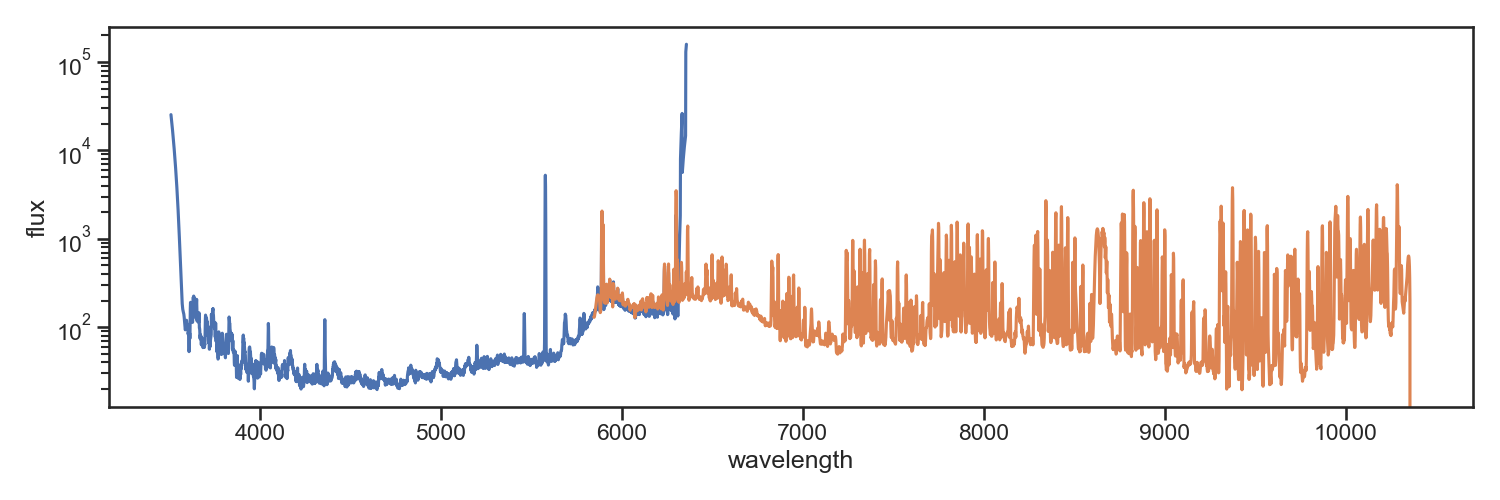

In [7]:
ised = 600

blue_mask = blue_sky["MASK"].data[ised] == 0
red_mask = red_sky["MASK"].data[ised] == 0


plt.figure(figsize=(15,5))
plt.semilogy(blue_wave_rss[ised][blue_mask], blue_sky["SKY"].data[ised][blue_mask])
plt.semilogy(red_wave_rss[ised][red_mask], red_sky["SKY"].data[ised][red_mask])
plt.xlabel("wavelength")
plt.ylabel("flux")
plt.tight_layout()


In [75]:
from lvmdrp.core.spectrum1d import Spectrum1D


blue_sed = Spectrum1D(
    wave=blue_wave_rss[ised],
    data=blue_sky["SKY"].data[ised],
    error=np.divide(1, np.sqrt(blue_sky["IVAR"].data[ised]), where=blue_sky["IVAR"].data[ised] > 0, out=1e12*np.ones(blue_sky["SKY"].data.shape[1])),
    mask=blue_sky["MASK"].data[ised] != 0,
    inst_fwhm=blue_sky["LSFPOST"].data[ised]
)
red_sed = Spectrum1D(
    wave=red_wave_rss[ised],
    data=red_sky["SKY"].data[ised],
    error=np.divide(1, np.sqrt(red_sky["IVAR"].data[ised]), where=red_sky["IVAR"].data[ised] > 0, out=1e12*np.ones(red_sky["SKY"].data.shape[1])),
    mask=red_sky["MASK"].data[ised] != 0,
    inst_fwhm=red_sky["LSFPOST"].data[ised]
)

[nan nan nan ... nan nan nan]


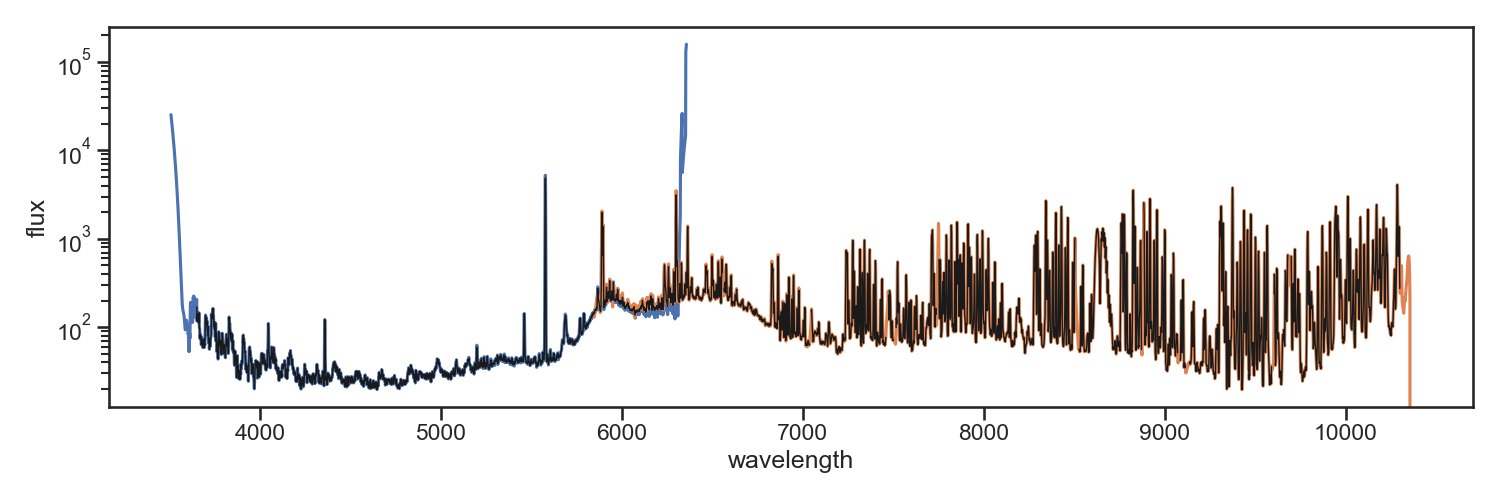

In [85]:
plt.figure(figsize=(15,5))
plt.semilogy(blue_sed._wave[~blue_sed._mask], blue_sed._data[~blue_sed._mask])
plt.semilogy(red_sed._wave[~red_sed._mask], red_sed._data[~red_sed._mask])

joint_sky = blue_sed.coaddSpec(red_sed)
wl_mask = (joint_sky._wave >= 3650) & (joint_sky._wave <= 10300)
joint_sky = Spectrum1D(
    wave=joint_sky._wave[wl_mask],
    data=joint_sky._data[wl_mask],
    mask=joint_sky._mask[wl_mask],
    error=joint_sky._error[wl_mask],
    inst_fwhm=joint_sky._inst_fwhm[wl_mask]
)

plt.semilogy(joint_sky._wave, joint_sky._data, color="k", lw=1)

plt.xlabel("wavelength")
plt.ylabel("flux")
plt.tight_layout()


In [89]:
from scipy.optimize import nnls


# read continuum templates
sky_cont_path = "_data-sky/sky-cont.rss.fits"
sky_cont = fits.open(sky_cont_path)
wl = sky_cont[0].header["CRVAL"] + np.arange(sky_cont[0].header["NAXIS1"]) * sky_cont[0].header["CDELT"]
sky_cont_templates = sky_cont[0].data
# convolve and resample templates
templates = []
for template in sky_cont_templates:
    temp_sed = Spectrum1D(wave=wl, data=template, inst_fwhm=wl/3000)
    # BUG: this won't work correctly until I implement LSF interpolation
    temp_sed_rs = temp_sed.resampleSpec(ref_wave=joint_sky._wave)
    temp_sed_rs.matchFWHM(target_FWHM=joint_sky._inst_fwhm)
    templates.append(temp_sed_rs._data)
templates = np.asarray(templates)
# find best fit for continuum sky component


In [62]:
target_sky = joint_sky._data
target_sky[np.isnan(target_sky)] = 0.0
error = joint_sky._error
error[np.isnan(error)] = np.inf

weights, norm = nnls(A=(templates/error[None,:]).T, b=(target_sky/error))
print(norm)


680.3047863576588


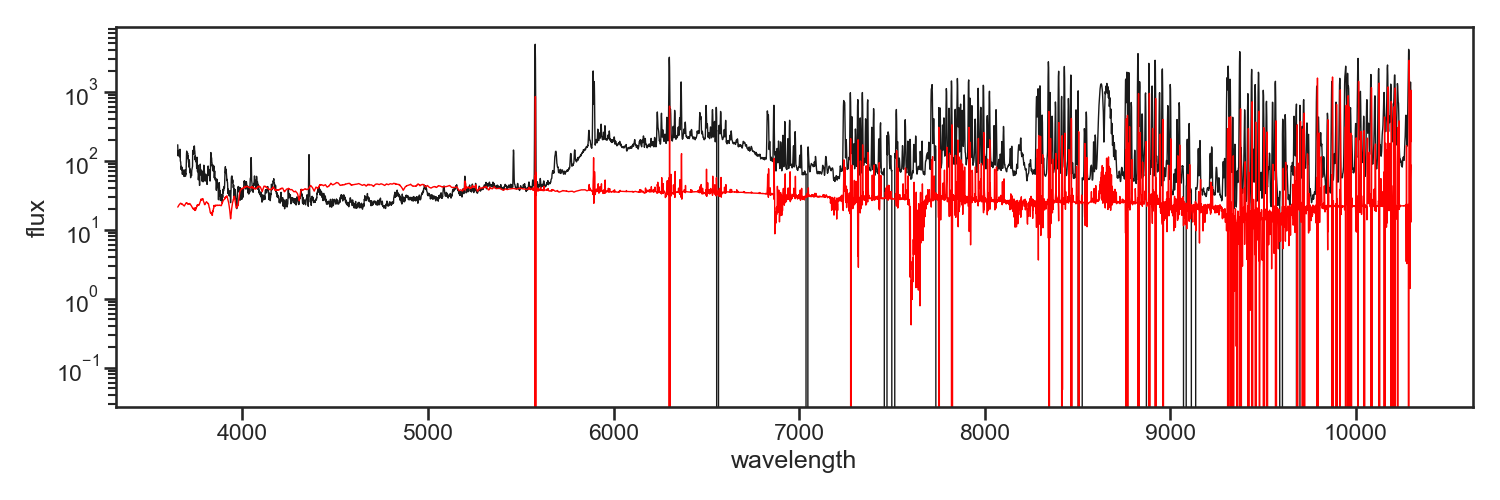

In [63]:
cont_model = np.dot(templates.T, weights)

plt.figure(figsize=(15, 5))
plt.semilogy(joint_sky._wave, joint_sky._data, color="k", lw=1)
plt.semilogy(joint_sky._wave, cont_model, color="red", lw=1)

plt.xlabel("wavelength")
plt.ylabel("flux")
plt.tight_layout()


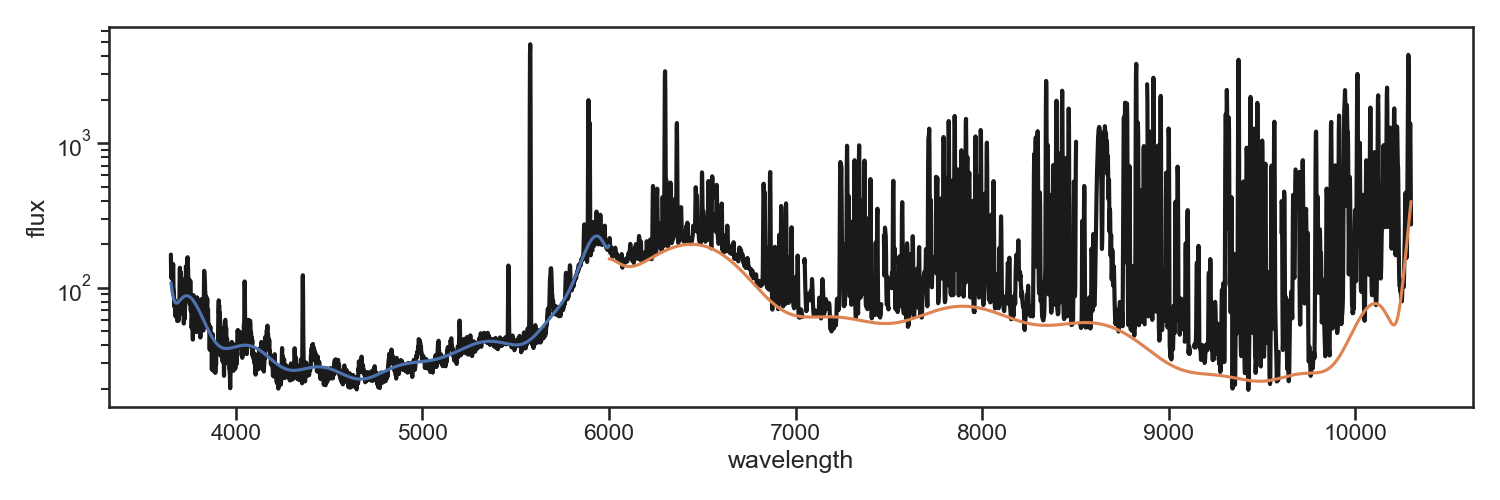

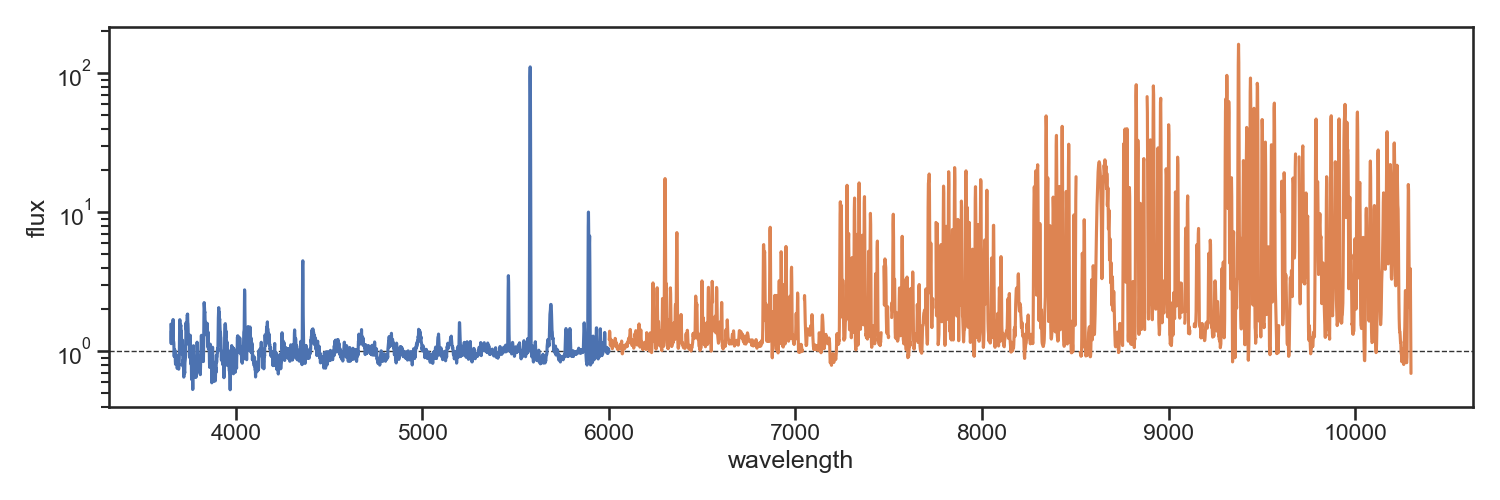

In [10]:
# sources:
# NIR sky emission: https://www.researchgate.net/publication/234230583_Night-sky_spectral_atlas_of_OH_emission_lines_in_the_near-infrared


from specutils.fitting import fit_generic_continuum
from specutils import Spectrum1D as Spec1D, SpectralRegion
from specutils.manipulation import extract_region
from astropy import units as u
from astropy.modeling import models
from astropy.modeling import fitting
from scipy.stats import binned_statistic


sky_sed = Spec1D(flux=joint_sky._data*u.erg/u.s/u.cm**2/u.AA, spectral_axis=joint_sky._wave*u.AA)

b_mask = joint_sky._wave<=6000
r_mask = joint_sky._wave>6000

blue = extract_region(sky_sed, region=SpectralRegion(0*u.AA, 6000*u.AA))
red = extract_region(sky_sed, region=SpectralRegion(6000*u.AA, 90000*u.AA))

min, xe, _ = binned_statistic(
    x=red.wavelength,
    values=red.flux,
    statistic=np.min,
    bins=np.logspace(
        start=np.log10(red.wavelength.value.min()),
        stop=np.log10(red.wavelength.value.max()),
        num=50
    )
)
xbin = (xe[1:] + xe[:-1])/2

red_bin = Spec1D(flux=min*u.erg/u.s/u.cm**2/u.AA, spectral_axis=xbin*u.AA)

# plt.figure(figsize=(20, 5))
# plt.semilogy(red.wavelength, red.flux)
# plt.semilogy(xbin, min, "ok")

blue_cont = fit_generic_continuum(
    spectrum=blue,
    model=models.Legendre1D(20),
    median_window=31,
    fitter=fitting.LinearLSQFitter()
)
red_cont = fit_generic_continuum(
    spectrum=red_bin,
    model=models.Legendre1D(20),
    median_window=1,
    fitter=fitting.LinearLSQFitter()
)

plt.figure(figsize=(15, 5))
plt.semilogy(sky_sed.wavelength, sky_sed.flux, color="k", lw=3)
plt.semilogy(blue.wavelength, blue_cont(blue.wavelength))
plt.semilogy(red.wavelength, red_cont(red.wavelength))
plt.xlabel("wavelength")
plt.ylabel("flux")
plt.tight_layout()

plt.figure(figsize=(15, 5))
plt.axhline(1, ls="--", lw=1, color="0.2")
plt.semilogy(blue.wavelength, blue.flux/blue_cont(blue.wavelength))
plt.semilogy(red.wavelength, red.flux/red_cont(red.wavelength))
plt.xlabel("wavelength")
plt.ylabel("flux")
plt.tight_layout()


In [11]:
# build iterative way of removing sky continuum by lowering the polynomial degree in each step
# take into account line blending
# library of ESO sky: airglow, cont and atm transmission only
#   skycorr: https://github.com/ryanhoughton/PySkyCorr
#   skycalc: https://www.eso.org/observing/etc/doc/skycalc/helpskycalccli.html


In [12]:
from lvmdrp.core import sky


sky_meta, sky_comp = sky.get_sky_model(wmin=365, wmax=1040, wres=3000, observatory="lasilla")
# sky_meta

In [13]:
# read about shadow hight calculation code
# lvmsurveysim/utils/shadow_height_lib.py
# this is for the sky fields selection (before sky selection)
# sh > 1000 km
# play with data that is not simultaneous
# test with fiber positioning data
# explore MWM sky data
# explore MaNGA data (take into account different times)
# document datamodel

<TableColumns names=('lam','flux','dflux1','dflux2','trans','dtrans1','dtrans2','flux_sml','flux_ssl','flux_zl','flux_tie','flux_tme','flux_ael','flux_arc','trans_ma','trans_o3','trans_rs','trans_ms')>


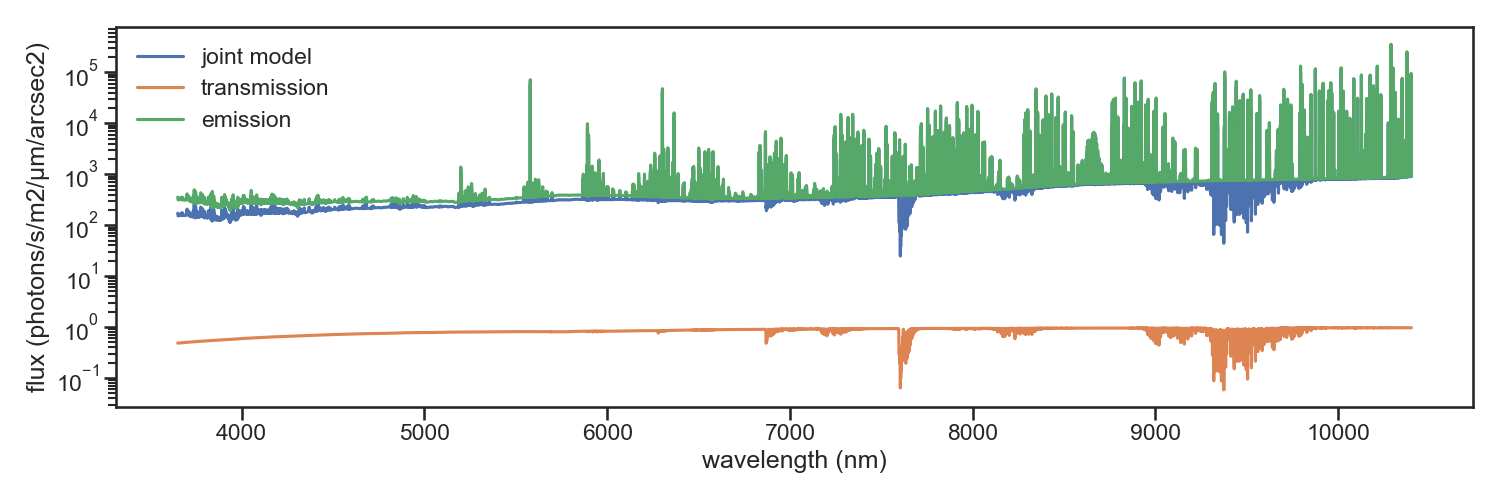

In [14]:
print(sky_comp.columns)


plt.figure(figsize=(15,5))
plt.semilogy(sky_comp["lam"], sky_comp["flux"], label="joint model")
plt.semilogy(sky_comp["lam"], sky_comp["trans"], label="transmission")
plt.semilogy(sky_comp["lam"], sky_comp["flux"]/sky_comp["trans"], label="emission")
plt.legend(loc=0, frameon=False)
plt.xlabel("wavelength (nm)")
plt.ylabel("flux (photons/s/m2/μm/arcsec2)")
plt.tight_layout()

In [15]:
def z2airmass(deg):
    return 1/np.cos(deg*np.pi/180)

def airmass2deg(air):
    return np.arccos(1/air)*180/np.pi

airmass = [1.0, 2.1, 2.7]
moon_alt = 45

grid_params = {"moon_target_sep": [np.abs(airmass2deg(air)+(90-moon_alt)) for air in airmass]}
print(grid_params)


comps = {}
comps_ = []
for parname, vals in grid_params.items():
    for air, moon_target_sep in zip(airmass, vals):
        meta, comp = sky.get_sky_model(wmin=365, wmax=1040, wres=3000, observatory="lasilla", airmass=air, moon_alt=moon_alt, moon_target_sep=moon_target_sep)
        comps_.append(comp)
    comps[parname] = comps_

{'moon_target_sep': [45.0, 106.56310985114463, 113.26153920847952]}


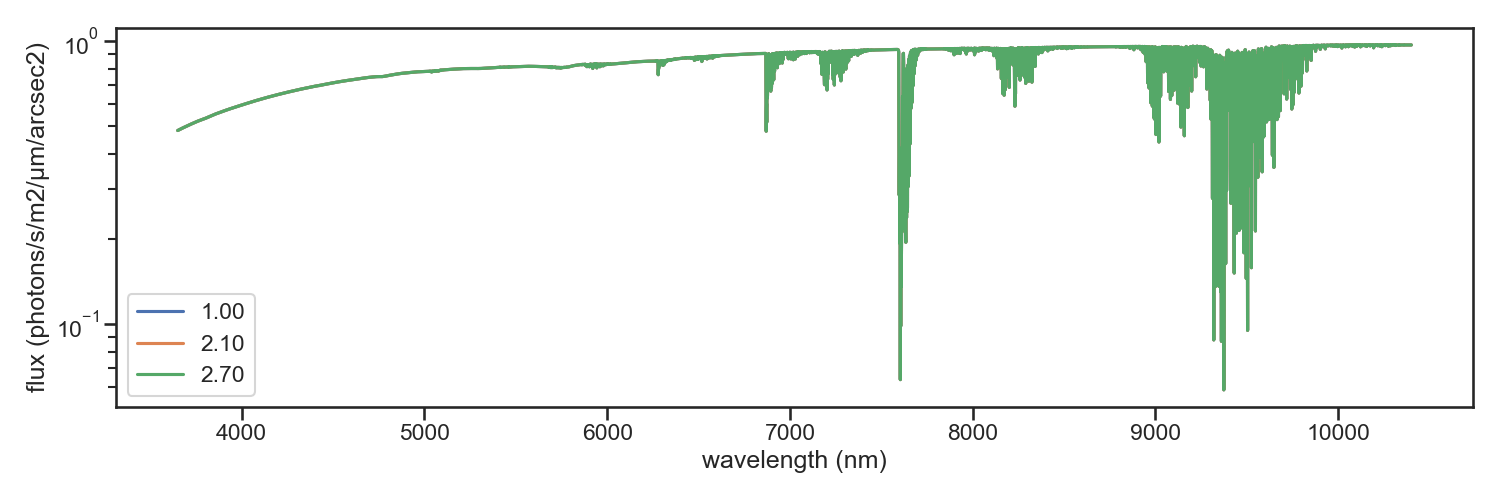

In [16]:
plt.figure(figsize=(15,5))

for parname, vals in comps.items():
    for air, comp in zip(airmass, comps[parname]):

        plt.semilogy(comp["lam"], comp["trans"], label=f"{air:.2f}")

plt.legend(loc=0)
plt.xlabel("wavelength (nm)")
plt.ylabel("flux (photons/s/m2/μm/arcsec2)")
plt.tight_layout()